Samsung 주가 
============

In [2]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pmdarima.arima import ndiffs
import pmdarima as pm

In [3]:
df_krx = fdr.StockListing('KRX')
len(df_krx)

6912

In [4]:
symbol = df_krx[df_krx['Name']== '삼성전자']['Symbol']
samsung = fdr.DataReader(''.join(symbol.values),start='2020-01-01',end='2021-12-31')

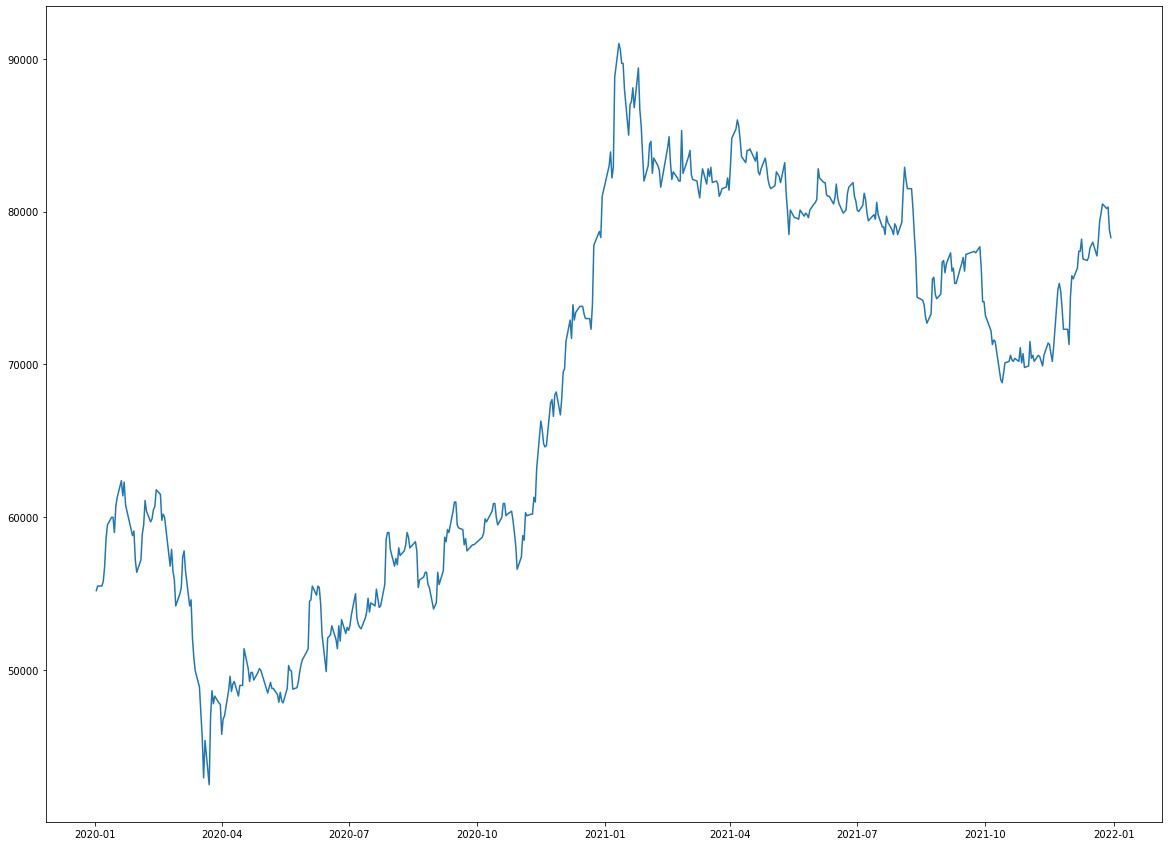

In [5]:
plt.figure(figsize=(20,15))
plt.plot(samsung.Close)

<AxesSubplot:xlabel='Date'>

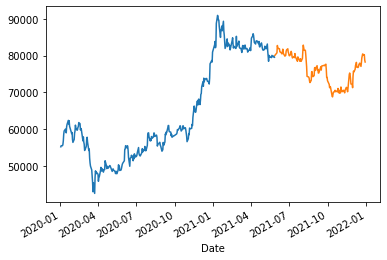

In [6]:
y_train = samsung.Close[:int(0.7 *len(samsung))]
y_test = samsung.Close[int(0.7*len(samsung)):]

y_train.plot()
y_test.plot()

#### 차분 차수 찾기 

In [7]:
kpss_diffs= ndiffs(y_train, alpha=0.05, test='kpss',max_d=6) # 초적 차분 찾는 방법 
adf_diffs = ndiffs(y_train,alpha=0.05, test='adf',max_d=6)
n_diffs = max(adf_diffs,kpss_diffs)

print(f'적정 차분 차수 {n_diffs}')

적정 차분 차수 1


- y: array 형태의 시계열 자료  
- d (기본값 = none): 차분의 차수, 이를 지정하지 않으면 실행 기간이 매우 길어질 수 있음  
- start_p (기본값 = 2), max_p (기본값 = 5): AR(p)를 찾을 범위 - (start_p에서 max_p까지 찾는다!)  
- start_q (기본값 = 2), max_q (기본값 = 5): AR(q)를 찾을 범위 (start_q에서 max_q까지 찾는다!)  
- m (기본값 = 1): 계절적 차분이 필요할 때 쓸 수 있는 모수로 m=4m=4이면 분기별, m=12m=12면 월별, m=1m=1이면 계절적 특징을 띠지 않는 데이터를 의미한다. m=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정된다.  
- seasonal (기본값 = True): 계절성 ARIMA 모형을 적합할지의 여부  
- stepwise (기본값 = True): 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부, False면 모든 모수 조합으로 모형을 적합한다.  
- trace (기본값 = False): stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용한다.  

In [8]:
model = pm.auto_arima(y=y_train, 
              d=1,
              start_p = 0, max_p=3,
              start_q = 0, max_q=3,
              seasonal=False,
              stepwise=True,
              trace=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5890.906, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5892.850, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5892.866, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5890.105, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5894.864, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.176 seconds


In [9]:
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
y_predict = model.predict(n_periods=len(y_test))
y_predict = pd.DataFrame(y_predict, index =y_test.index, columns=['Prediction'])
y_predict

,Prediction
Date,
2021-05-28,79600.0
2021-05-31,79600.0
2021-06-01,79600.0
2021-06-02,79600.0
2021-06-03,79600.0
...,...
2021-12-24,79600.0
2021-12-27,79600.0
2021-12-28,79600.0


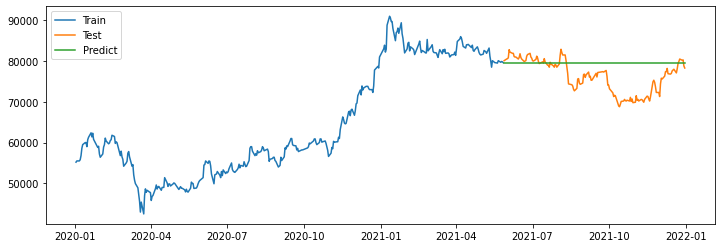

In [11]:
fig, axes = plt.subplots(figsize=(12,4))
plt.plot(y_train, label= 'Train')
plt.plot(y_test, label='Test')
plt.plot(y_predict,label='Predict')
plt.legend()

- 결과 엉망이당

In [12]:
y_test

Date
2021-05-28    80100
2021-05-31    80500
2021-06-01    80600
2021-06-02    80800
2021-06-03    82800
              ...  
2021-12-24    80500
2021-12-27    80200
2021-12-28    80300
2021-12-29    78800
2021-12-30    78300
Name: Close, Length: 149, dtype: int64

#### 다시 제대로 예측해보기

In [13]:
def forecast_one_step():
    fc, conf_int =model.predict(n_periods=1,return_conf_int=True)
    
    return fc.tolist()[0], np.asarray(conf_int).tolist()[0]
    

In [14]:
forecast_one_step()  #[,] : 신뢰구간

(79600.0, [77251.89428339618, 81948.10571660382])

In [15]:
forecast_list = []
y_pred = []
pred_upper = []
pred_lower = []

for i in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    
    model.update(i)
    


In [16]:
y_pred

[79600.0,
 80100.0,
 80500.0,
 80600.0,
 80800.0,
 82800.0,
 82200.0,
 81900.0,
 81900.0,
 81100.0,
 81000.0,
 81000.0,
 80500.0,
 80900.0,
 81800.0,
 80900.0,
 80500.0,
 79900.0,
 80000.0,
 80100.0,
 81200.0,
 81600.0,
 81900.0,
 81000.0,
 80700.0,
 80100.0,
 80000.0,
 80400.0,
 81200.0,
 80800.0,
 79900.0,
 79400.0,
 79700.0,
 79800.0,
 79500.0,
 80600.0,
 79800.0,
 79000.0,
 79000.0,
 78500.0,
 79700.0,
 79300.0,
 78800.0,
 78500.0,
 79200.0,
 79000.0,
 78500.0,
 79300.0,
 81400.0,
 82900.0,
 82100.0,
 81500.0,
 81500.0,
 80200.0,
 78500.0,
 77000.0,
 74400.0,
 74200.0,
 73900.0,
 73100.0,
 72700.0,
 73300.0,
 75600.0,
 75700.0,
 74600.0,
 74300.0,
 74600.0,
 76700.0,
 76800.0,
 76000.0,
 76600.0,
 77300.0,
 76100.0,
 76300.0,
 75300.0,
 75300.0,
 76300.0,
 76600.0,
 77000.0,
 76100.0,
 77200.0,
 77400.0,
 77300.0,
 77700.0,
 76300.0,
 74100.0,
 74100.0,
 73200.0,
 72200.0,
 71300.0,
 71600.0,
 71500.0,
 69000.0,
 68800.0,
 69400.0,
 70100.0,
 70200.0,
 70600.0,
 70300.0,
 70200.0,


In [17]:
y_pred_2 = pd.DataFrame({'test':y_test,'pred':y_pred})

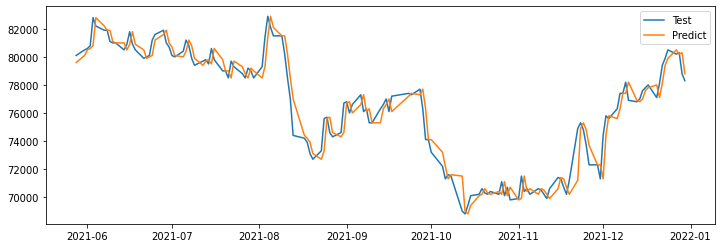

In [18]:
fig, axes = plt.subplots(figsize=(12,4))
#plt.plot(y_train, label= 'Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred_2.pred,label='Predict')
plt.legend()

In [19]:
import plotly

In [20]:
import plotly.graph_objects as go 
fig = go.Figure([go.Scatter(x=y_train.index, y=y_train, name='Train', mode='lines', line=dict(color='red')),
                 #테스트데이터
                 go.Scatter(x=y_test.index, y=y_test, name='Test', mode='lines', line=dict(color='rgba(0,0,30,0.5)')),
                 #예측 데이터
                 go.Scatter(x=y_test.index, y=y_pred, name='Pred', mode='lines', line=dict(color='yellow',dash='dot',width=3)),
                 #신뢰구간
                 go.Scatter(x=y_test.index.tolist() + y_test.index[::-1].tolist(), y=pred_upper+pred_lower[::-1],fill = 'toself',fillcolor='rgba(0,0,30,0.1)',line={'color':'rgba(0,0,0,0)'},hoverinfo="skip",showlegend=True)])


fig.update_layout(height=420, width=1080, title_text='ARIMA(0,1,0)')
fig.show()